In [3]:
from collections import defaultdict,OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from sklearn.preprocessing import MultiLabelBinarizer

    
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression

from scipy.stats import entropy
import string


import datetime
import numpy as np
from joblib import Parallel, delayed
from time import sleep
from utils import *
from sklearn.mixture import BayesianGaussianMixture
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import importlib
import utils
import warnings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
import networkx as nx

import pandas as pd
import leidenalg
import igraph as ig
import seaborn as sns
from pyvis.network import Network
from IPython.display import display, HTML

importlib.reload(utils)
import webbrowser


In [4]:
def create_category_graph(df):
    G = nx.Graph()
    for row in df.itertuples(index=False):
        categories = row.category_list.split(',')
        for cat1, cat2 in zip(categories, categories[1:]):
            cat1 = cat1.strip()
            cat2 = cat2.strip()
            if G.has_edge(cat1, cat2):
                G[cat1][cat2]['weight'] += 1
            else:
                G.add_edge(cat1, cat2, weight=1)
    return G

def networkx_to_igraph(nx_graph):
    ig_graph = ig.Graph(directed=nx_graph.is_directed())
    mapping = {name: idx for idx, name in enumerate(nx_graph.nodes())}
    
    ig_graph.add_vertices(len(mapping))
    for name, idx in mapping.items():
        ig_graph.vs[idx]['name'] = name

    edges = [(mapping[u], mapping[v]) for u, v in nx_graph.edges()]
    ig_graph.add_edges(edges)
    weights = [nx_graph[u][v]['weight'] for u, v in nx_graph.edges()]
    ig_graph.es['weight'] = weights
    
    return ig_graph

def print_random_node_properties(graph, num_nodes=10):
    # Ensure we don't try to sample more nodes than exist in the graph
    num_nodes = min(num_nodes, len(graph.nodes))

    # Sample random nodes
    random_nodes = random.sample(graph.nodes, num_nodes)

    # Print the properties of the sampled nodes
    for node in random_nodes:
        print(f"Node: {node}")
        for key, value in graph.nodes[node].items():
            print(f"  {key}: {value}")
        print()  # Print a blank line for better readability

def show_clusters(df,
                  dimension_labels,
                  colors,
                  Z,
                  normalized=True, 
                  difference=False,
                  clusters = 7):

    cluster_labels = fcluster(Z, t=clusters, criterion='maxclust')

    # Extract the fingerprint of each cluster
    fingerprints = []
    for cluster in range(1, clusters+1):
        cluster_members = df.iloc[cluster_labels == cluster]
        fingerprint = cluster_members.mean().values
        fingerprints.append(fingerprint)


    # Number of arrays and dimensions
    if normalized:
        normalized_arrays = [array / np.sum(array) for array in fingerprints]
        if difference:
            rep_fing = normalized_arrays[0]
            normalized_arrays = [rep_fing - fing for fing in normalized_arrays]
    else:
        normalized_arrays = fingerprints

    n_arrays = len(normalized_arrays)
    n_dimensions = len(normalized_arrays[0])

    # X locations for the groups
    indices = np.arange(n_arrays)

    # Width of a bar
    bar_width = 0.1

    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(20, 6))

    # Generate bars for each dimension and add labels
    for j in range(n_dimensions):
        values = [array[j] for array in normalized_arrays]
        ax.bar(indices + j * bar_width, values, bar_width, color=colors[j], label=dimension_labels[j])

    # Add some text for labels, title, and axes ticks
    ax.set_xlabel('Cities Fingerprints')
    ax.set_ylabel('Values')
    ax.set_title('Bar Chart of Arrays')
    ax.set_xticks(indices + bar_width * (n_dimensions - 1) / 2)
    ax.set_xticklabels([f'Cluster {i+1}' for i in range(n_arrays)])

    # Create custom legend
    legend_handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(n_dimensions)]
    bbox_coords = (1.02, 0.5)  # x, y coordinates for the legend box
    ax.legend(legend_handles, dimension_labels, title="Dimensions", bbox_to_anchor=bbox_coords, loc='center left', borderaxespad=0.)
    # Display the plot
    plt.tight_layout()
    plt.show()

In [5]:
groups = {
    'ExCo': ['ceo', 'cto', 'cfo', 'coo', 'cmo', 'cio', 'cso', 'cpo', 'cco', 'cro', 'svp', 'evp', 'cdo', 'cbo', 'cxo'],
    'Founder': ['founder'],
    'Engineering': ['software engineer', 'data scientist'],
    'Leadership': ['president', 'managing director', 'director', 'vp', 'chairman', 'executive director', 'general manager', 'vp engineering'],
    'Board': ['board member', 'member board director', 'board directors', 'chairman board', 'advisory board member', 'board observer'],
    'Ownership': ['owner', 'partner', 'managing partner', 'founding partner'],
    'Investor':['investor'],
    'Advisory': ['advisor', 'consultant'],
    'Other': ['member', 'team member', 'associate', 'product manager', 'principal']
}

In [7]:
df_org         = pd.read_csv('../data/organizations.csv')
df_jobs        = pd.read_csv('../data/jobs.csv')
df_people      = pd.read_csv('../data/people.csv')
# df_fund_rounds = pd.read_csv('../data/funding_rounds.csv')
# df_ipos        = pd.read_csv('../data/ipos.csv')

In [8]:
pple_new_roles = df_jobs.copy()
pple_new_roles['cleaned_title'] = pple_new_roles['title'].apply(lambda x: clean_text(x))
sorted_counts = pple_new_roles.groupby('cleaned_title')['cleaned_title'].count().sort_values(ascending=False)
sorted_counts_df = sorted_counts.reset_index(name='count')

In [9]:
chief_job_dataframe = (
    find_job_word(sorted_counts_df,'cleaned_title','chief')
    .groupby('cleaned_title')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .rename(columns={'index': 'chief_jobs'})
)

## Chief analysis

In [10]:
cumulative_chief = (
    find_job_word(sorted_counts_df,'cleaned_title','chief')
    .reset_index()  # Reset the index to make it a column
    .assign(cumulative_count=lambda x: x['count'].cumsum())  # Add a new column with cumulative sum
)

norm = cumulative_chief['cumulative_count'].tail(1).values[0]
cumulative_chief['percentage_cumulative']=cumulative_chief['cumulative_count']/norm
cumulative_chief['abbreviated_cleaned_title']=cumulative_chief['cleaned_title'].apply(abbreviate_title)

cumulative_chief['abbreviated_cleaned_title_round2']=cumulative_chief['abbreviated_cleaned_title'].apply(abbreviate_title_round_2)

cumulative_chief['abbreviated_cleaned_title_round3']=cumulative_chief['abbreviated_cleaned_title_round2'].apply(lambda x: remove_executives(x))
# cumulative_chief.head(5)

# cumulative_chief[cumulative_chief['percentage_cumulative']<0.60]

chief_df = find_job_word(sorted_counts_df,'cleaned_title','chief')
chief_df['abbreviated_cleaned_title']=chief_df['cleaned_title'].apply(abbreviate_title)
chief_df['abbreviated_cleaned_title_round2']=chief_df['abbreviated_cleaned_title'].apply(abbreviate_title_round_2)
chief_df['abbreviated_cleaned_title_round3']=chief_df['abbreviated_cleaned_title_round2'].apply(lambda x: remove_executives(x))


In [11]:
# Create a dictionary mapping cleaned_title to abbreviated_cleaned_title_round3
title_mapping = chief_df.set_index('cleaned_title')['abbreviated_cleaned_title_round3'].to_dict()

# Merge df1 and df2, keeping all rows from df1
new_df = pd.merge(pple_new_roles, chief_df[['cleaned_title', 'abbreviated_cleaned_title_round3']], 
                  how='left', 
                  on='cleaned_title')

# Create the final_title column
new_df['final_title'] = new_df['cleaned_title'].where(
    ~new_df['cleaned_title'].isin(title_mapping),
    new_df['abbreviated_cleaned_title_round3']
)

new_df = new_df.dropna(subset=['started_on'])

new_df['final_final_title'] = new_df['final_title'].apply(move_founder_to_end)

In [12]:
# mask = new_df['title'].str.contains('director', case=False, regex=True) & new_df['title'].notna()
# chief_titles = new_df[mask]
# chief_titles.groupby(by=['job_type']).count()

# tmp_df = new_df\
#     .groupby('final_final_title')\
#     .size()\
#     .reset_index(name='count')\
#     .sort_values(by='count', ascending=False)\
#     .rename(columns={'index': 'three_letter_title'}).head(60)

# cumulative_tmp_df = (
#     tmp_df
#     .reset_index()  # Reset the index to make it a column
#     .assign(cumulative_count=lambda x: x['count'].cumsum())  # Add a new column with cumulative sum
# )

# norm = cumulative_tmp_df['cumulative_count'].tail(1).values[0]

# cumulative_tmp_df['percentage_cumulative']=cumulative_tmp_df['cumulative_count']/norm

# cumulative_tmp_df.head(10)

In [13]:
tmp_df = new_df\
    .groupby('final_final_title')\
    .size()\
    .reset_index(name='count')\
    .sort_values(by='count', ascending=False)\
    .rename(columns={'index': 'three_letter_title'}).head(60)

cumulative_tmp_df = (
    tmp_df
    .reset_index()  # Reset the index to make it a column
    .assign(cumulative_count=lambda x: x['count'].cumsum())  # Add a new column with cumulative sum
)

norm = cumulative_tmp_df['cumulative_count'].tail(1).values[0]

cumulative_tmp_df['percentage_cumulative']=cumulative_tmp_df['cumulative_count']/norm

# cumulative_tmp_df.head(10)

In [14]:
three_letter_titles = (
    new_df[new_df['cleaned_title'].str.len() == 3]
    .groupby('cleaned_title')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .rename(columns={'index': 'three_letter_title'})
)

cumulative_three_letter = (
    three_letter_titles
    .reset_index()  # Reset the index to make it a column
    .assign(cumulative_count=lambda x: x['count'].cumsum())  # Add a new column with cumulative sum
)

norm = cumulative_three_letter['cumulative_count'].tail(1).values[0]

cumulative_three_letter['percentage_cumulative']=cumulative_three_letter['cumulative_count']/norm

# cumulative_three_letter.head(10)

In [15]:
# Call the group_roles function
grouped_df = group_roles(new_df, 'final_final_title', groups)
grouped_df['group'] = grouped_df['group'].apply(lambda x: x if isinstance(x, list) else [x])

In [16]:
df_jobs_cleaned = grouped_df[['started_on','org_uuid','group']]
df_jobs_cleaned['started_on'] = pd.to_datetime(df_jobs_cleaned['started_on'], errors='coerce')
df_jobs_cleaned = df_jobs_cleaned[df_jobs_cleaned['started_on'].notna()]

df_org_foundation = df_org[['uuid', 'founded_on','country_code','city','total_funding_usd']]
# Convert the 'founded_on' column to datetime
df_org_foundation['founded_on'] = pd.to_datetime(df_org_foundation['founded_on'], errors='coerce')
# Drop rows with NaN values (including out-of-bounds datetime)
df_org_foundation = df_org_foundation[df_org_foundation['founded_on'].notna()]
df_org_foundation = df_org_foundation[df_org_foundation['country_code'].notna()]

dimension_labels = list(groups.keys())


In [17]:
colors = sns.color_palette("tab10", n_colors=len(dimension_labels))

In [29]:
start_year = 2000
end_year = start_year+1
df_org_filtered  = filter_by_year_range(df_org_foundation,'founded_on',start_year,end_year)
df_jobs_filtered = filter_by_year_range(df_jobs_cleaned,'started_on',start_year,end_year)

# Count the occurrences of cities in df_org_filtered
city_counts = df_org_filtered['city'].value_counts()

# Filter the city counts based on the minimum count
minimum_count = 100
filtered_city_counts = city_counts[city_counts >= minimum_count]

# df_tmp = pd.DataFrame(filtered_city_counts).reset_index().rename(columns={'index':'city','city':'count'})

df_org_filtered = df_org_filtered[df_org_filtered.city.isin(filtered_city_counts.index.tolist())]

df_merge = pd.merge(df_org_filtered, df_jobs_filtered, left_on='uuid',right_on='org_uuid')

# Explode the 'groups' column into rows
exploded = df_merge.explode('group').reset_index(drop=True)

# Count the occurrences of unique elements, grouped by 'city' and 'groups'
group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

# Pivot the data to have the groups as columns
pivoted = group_counts.pivot(index='city', columns='group', values='count').fillna(0)

city_totals = pivoted.sum(axis=1)

minimum_count = 100
filtered_pivoted = pivoted[city_totals >= minimum_count]

len(filtered_pivoted)

22

In [30]:
# # Create the HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(metric='euclidean', cluster_selection_method='eom')
# cluster_labels = clusterer.fit_predict(filtered_pivoted)

# # Print the cluster labels
# print("Cluster labels:", cluster_labels)

# # Plot the dendrogram
# clusterer.condensed_tree_.plot(select_clusters=True)
# plt.title("Dendrogram")
# plt.show()

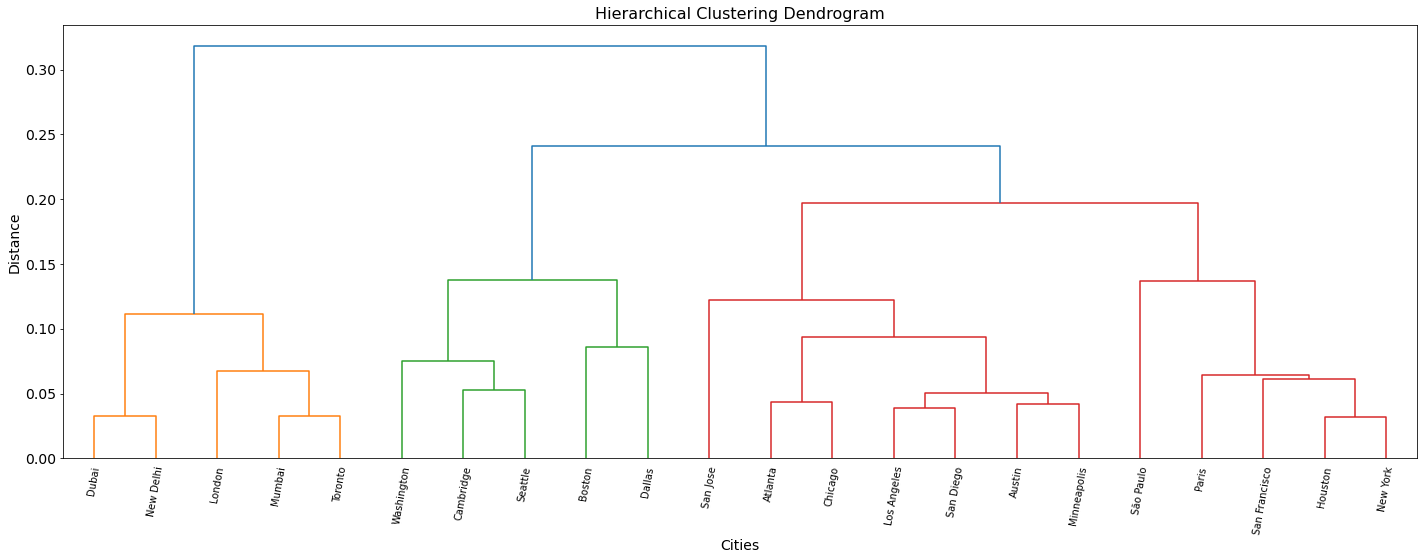

In [31]:
normalized_pivoted = filtered_pivoted.apply(lambda row: row / row.sum(), axis=1)

Z = linkage(normalized_pivoted, method='ward')

max_d = max(Z[:, 2])

threshold = 0.23

clusters = fcluster(Z, t=threshold, criterion='distance')


plt.figure(figsize=(20, 8))

# Generate the dendrogram
dendro = dendrogram(Z, labels=normalized_pivoted.index,show_leaf_counts=True,color_threshold=threshold)

# Customize the tick label font size
plt.setp(plt.gca().get_xticklabels(), fontsize=10)
plt.setp(plt.gca().get_yticklabels(), fontsize=14)

plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
plt.xlabel("Cities", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.xticks(rotation=80)  # Rotate x-axis labels if necessary

plt.tight_layout()
plt.show()

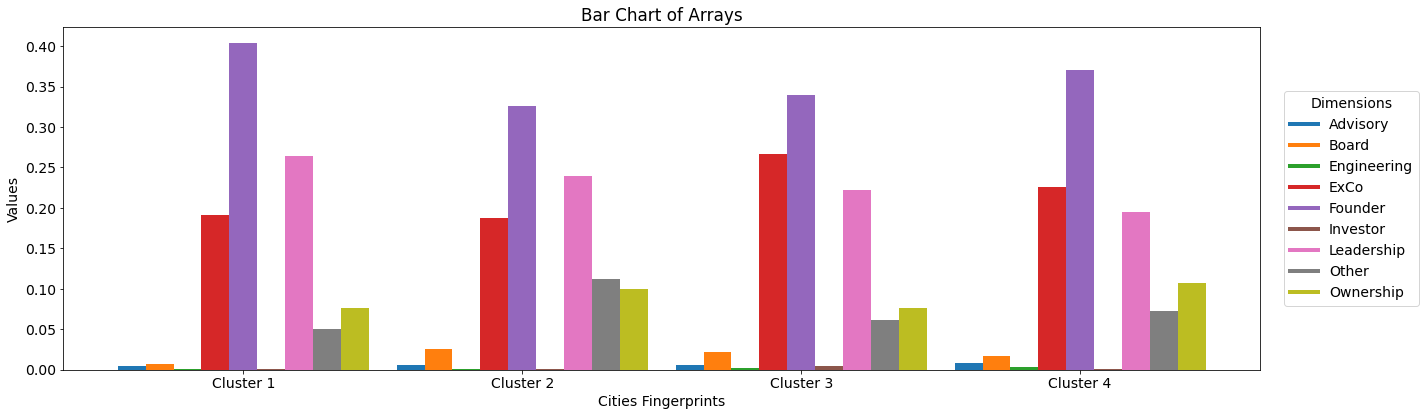

In [33]:
show_clusters(filtered_pivoted,
              list(filtered_pivoted.columns),
              colors,
                  Z,
              normalized=True, 
              difference=False,
              clusters = 4)       

Coppia Founder-Investor. Contare numero di link tra startup che sono legate tra loro tramite quel link. 

## Entropy and city trend

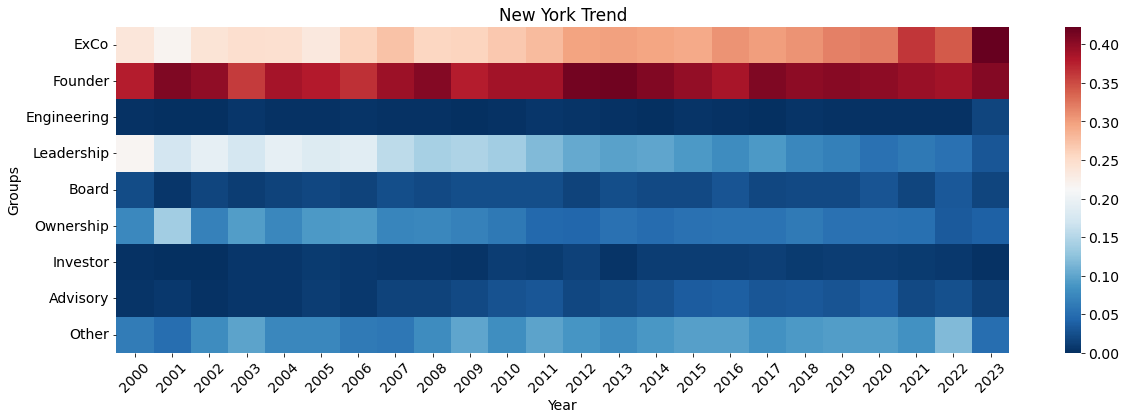

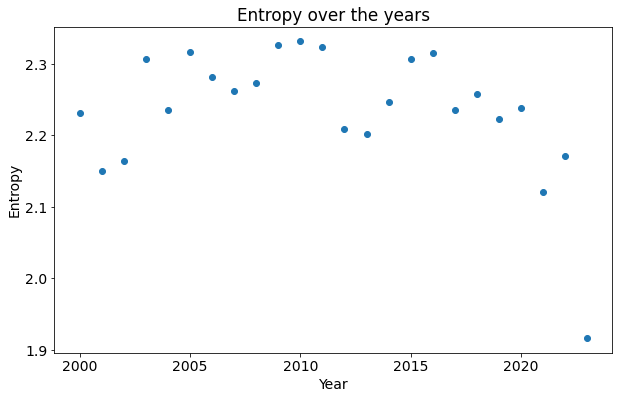

In [34]:
city = 'New York'
matrix = np.zeros((2024-2000,len(dimension_labels)))

unique_groups = dimension_labels

for year_index, start_year in enumerate(range(2000, 2024)):
    end_year = start_year
    df_org_filtered  = filter_by_year_range(df_org_foundation,'founded_on',start_year,end_year)
    df_jobs_filtered = filter_by_year_range(df_jobs_cleaned,'started_on',start_year,end_year)

    df_merge = pd.merge(df_org_filtered[df_org_filtered.city==city], df_jobs_filtered, left_on='uuid',right_on='org_uuid')

    # Explode the 'groups' column into rows
    exploded = df_merge.explode('group').reset_index(drop=True)

    # Count the occurrences of unique elements, grouped by 'city' and 'groups'
    group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

    # Normalize the group counts by the city totals
    if not group_counts.empty:
        group_counts['normalized_count'] = group_counts['count'] / group_counts['count'].sum()

        # Assign counts to the appropriate position in the matrix
        for i, group in enumerate(unique_groups):
            if group in group_counts['group'].values:
                matrix[year_index, i] = group_counts[group_counts['group'] == group]['normalized_count'].values[0]


# Transpose the matrix
transposed_matrix = matrix.T

# Create a DataFrame from the transposed matrix
heatmap_data = pd.DataFrame(transposed_matrix, columns=range(2000, 2024), index=unique_groups)

# Plot the heatmap with axes swapped
plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_data, cmap='RdBu_r', annot=False, linewidths=.002)
plt.title(city+' Trend')
plt.xlabel('Year')
plt.ylabel('Groups')
plt.xticks(rotation=45)

plt.show()

entropies = [entropy(group_counts, base=2) for group_counts in matrix]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(2000, 2024), entropies)
plt.title('Entropy over the years')
plt.xlabel('Year')
plt.ylabel('Entropy')
plt.show()

In [23]:
def calculate_angular_coeff(values):
    X = np.array([i for i in range(len(values))]).reshape(-1,1)
    # Create a range of values for the independent variable (e.g., time)
    y = values

    # Create and fit the linear regression model
    model = LinearRegression().fit(X, y)

    # Get the angular coefficient (slope)
    return model.coef_[0]

In [24]:
l_coeff = list()
city_coeff = defaultdict(float)
for city in list(filtered_pivoted.index):
    if city in ['Campbell','Johannesburg','Rockville','Waltham']:
        continue
    if city in city_coeff.keys():
        continue
    matrix = np.zeros((2021-2000,len(dimension_labels)))

    unique_groups = dimension_labels

    for year_index, start_year in enumerate(range(2000, 2021)):
        end_year = start_year
        df_org_filtered  = filter_by_year_range(df_org_foundation,'founded_on',start_year,end_year)
        df_jobs_filtered = filter_by_year_range(df_jobs_cleaned,'started_on',start_year,end_year)

        df_merge = pd.merge(df_org_filtered[df_org_filtered.city==city], df_jobs_filtered, left_on='uuid',right_on='org_uuid')

        # Explode the 'groups' column into rows
        exploded = df_merge.explode('group').reset_index(drop=True)

        # Count the occurrences of unique elements, grouped by 'city' and 'groups'
        group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

        # Normalize the group counts by the city totals
        if not group_counts.empty:
            group_counts['normalized_count'] = group_counts['count'] / group_counts['count'].sum()

            # Assign counts to the appropriate position in the matrix
            for i, group in enumerate(unique_groups):
                if group in group_counts['group'].values:
                    matrix[year_index, i] = group_counts[group_counts['group'] == group]['normalized_count'].values[0]


    # Transpose the matrix
    transposed_matrix = matrix.T

    entropies = [entropy(group_counts, base=2) for group_counts in matrix]
    
    # print(city)
    l_coeff.append(calculate_angular_coeff(entropies))
    city_coeff[city] = calculate_angular_coeff(entropies)



In [25]:
filtered_dict = {key: value for key, value in city_coeff.items() if value<=-0.01}
sorted(filtered_dict.items(), key=lambda item: item[1])

[('Bedford', -0.01585564934269041), ('Burlington', -0.013941887493704709)]

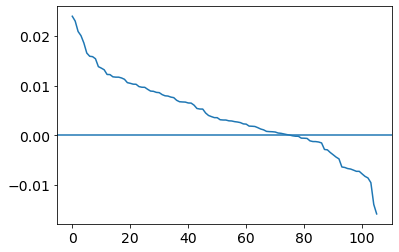

In [26]:
plt.plot(sorted(l_coeff,reverse=True))
plt.axhline(y=0)

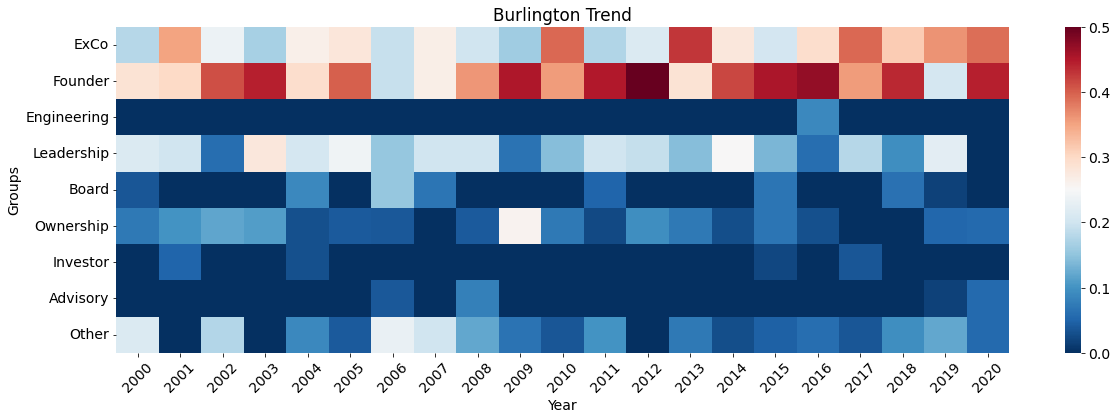

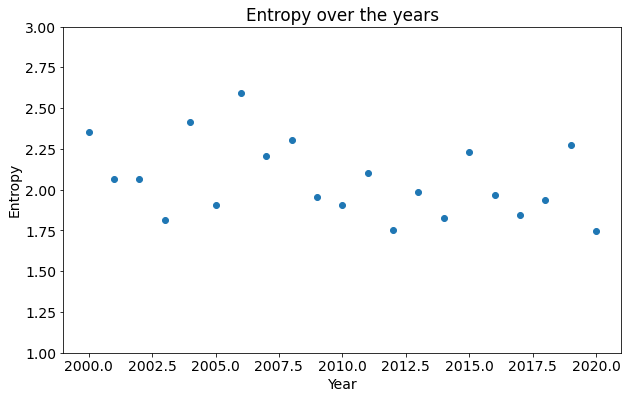

In [27]:
city = 'Burlington'
matrix = np.zeros((2021-2000,len(dimension_labels)))

unique_groups = dimension_labels

for year_index, start_year in enumerate(range(2000, 2021)):
    end_year = start_year
    df_org_filtered  = filter_by_year_range(df_org_foundation,'founded_on',start_year,end_year)
    df_jobs_filtered = filter_by_year_range(df_jobs_cleaned,'started_on',start_year,end_year)

    df_merge = pd.merge(df_org_filtered[df_org_filtered.city==city], df_jobs_filtered, left_on='uuid',right_on='org_uuid')

    # Explode the 'groups' column into rows
    exploded = df_merge.explode('group').reset_index(drop=True)

    # Count the occurrences of unique elements, grouped by 'city' and 'groups'
    group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

    # Normalize the group counts by the city totals
    if not group_counts.empty:
        group_counts['normalized_count'] = group_counts['count'] / group_counts['count'].sum()

        # Assign counts to the appropriate position in the matrix
        for i, group in enumerate(unique_groups):
            if group in group_counts['group'].values:
                matrix[year_index, i] = group_counts[group_counts['group'] == group]['normalized_count'].values[0]


# Transpose the matrix
transposed_matrix = matrix.T

# Create a DataFrame from the transposed matrix
heatmap_data = pd.DataFrame(transposed_matrix, columns=range(2000, 2021), index=unique_groups)

# Plot the heatmap with axes swapped
plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_data, cmap='RdBu_r', annot=False, linewidths=.002)
plt.title(city+' Trend')
plt.xlabel('Year')
plt.ylabel('Groups')
plt.xticks(rotation=45)

plt.show()

entropies = [entropy(group_counts, base=2) for group_counts in matrix]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(2000, 2021), entropies)
plt.ylim(1,3)
plt.title('Entropy over the years')
plt.xlabel('Year')
plt.ylabel('Entropy')
plt.show()

In [27]:
# # Convert the list to a NumPy array and reshape it
# X = np.array([i for i in range(len(entropies))]).reshape(-1,1)
# # Create a range of values for the independent variable (e.g., time)
# y = entropies

# # Create and fit the linear regression model
# model = LinearRegression().fit(X, y)

# # Get the angular coefficient (slope)
# angular_coefficient = model.coef_[0]

# print(f"Angular Coefficient (Slope): {angular_coefficient}")

# plt.scatter(X, y, color='blue')
# plt.plot(X, model.predict(X), color='red', linewidth=2)
# plt.title("Linear Regression")
# plt.xlabel("Values")
# plt.ylabel("Independent Variable")
# plt.show()

# Organizations Fingerprints

In [6]:
org_categories = df_org[['uuid', 'founded_on','country_code','category_list','category_groups_list','city']]
org_categories['founded_on'] = pd.to_datetime(org_categories['founded_on'], errors='coerce')
org_categories = org_categories[org_categories['founded_on'].notna()]
org_categories = org_categories[org_categories['category_groups_list'].notna()]
org_categories = org_categories[org_categories['category_list'].notna()]

In [7]:
def create_category_list_graph(df,is_list=True):
    G = nx.Graph()
    edge_counts = {}
    for row in df.itertuples(index=False):
        if is_list:
            categories = row.category_list.split(',')
        else:
            categories = row.category_groups_list.split(',')
        for cat1, cat2 in zip(categories, categories[1:]):
            cat1 = cat1.strip()
            cat2 = cat2.strip()
            edge = tuple(sorted([cat1, cat2]))
            edge_counts[edge] = edge_counts.get(edge, 0) + 1
            G.add_edge(cat1, cat2, weight=edge_counts[edge])
    for node in G.nodes:
        G.nodes[node]['label'] = node 
    return G

## Community analysis

In [30]:
# start_year = 2020
# end_year = 2021
networks = defaultdict()
# communities_dict = defaultdict()
for year in range(2000,2024):

    df_org_filtered = filter_by_year_range(org_categories,'founded_on',year,year+1)
    # print(len(df_org_filtered))

    category_graph = create_category_list_graph(df_org_filtered,is_list=True)
    mapping = {label: label for label in nx.get_node_attributes(category_graph, 'label').values()}
    integer_mapping = {i:label for i, label in enumerate(sorted(set(mapping.values())))}
    category_graph = nx.convert_node_labels_to_integers(category_graph,ordering='sorted',label_attribute='label')

    igraph_category_graph = networkx_to_igraph(category_graph)

    # Run the Leiden algorithm
    partition = leidenalg.find_partition(igraph_category_graph, 
                                        leidenalg.ModularityVertexPartition, 
                                        weights='weight')

    # print(f"Number of communities: {len(partition)}")

    # Map communities to nodes
    communities = {}
    for idx, community in enumerate(partition):
        for node in community:
            communities[igraph_category_graph.vs[node]['name']] = idx

    # Assign community to nodes in NetworkX graph
    community_mapping = {}
    for community_id, community in enumerate(partition):
        for node in community:
            community_mapping[integer_mapping[igraph_category_graph.vs[node]['name']]] = community_id

    G = nx.relabel_nodes(category_graph, integer_mapping)
    nx.set_node_attributes(G, community_mapping, 'community')

    networks[str(year)]= G

    # Save the graph in GEXF format
    nx.write_gexf(G, 'output_graph/category_graph_'+str(year)+'.gexf')

    # for community in partition:
    #     print(f"Community: {[igraph_category_graph.vs[i]['name'] for i in community]}")

In [31]:
G2 = networks['2001']
G1 = networks['2000']

# Find the edges present in G1 but not in G2
edges_in_G1_not_in_G2 = set(G1.edges) - set(G2.edges)
# print(f"Edges present in G1 but not in G2: {edges_in_G1_not_in_G2}")
print(len(edges_in_G1_not_in_G2))

# Find the edges present in G2 but not in G1
edges_in_G2_not_in_G1 = set(G2.edges) - set(G1.edges)
# print(f"Edges present in G2 but not in G1: {edges_in_G2_not_in_G1}")
print(len(edges_in_G2_not_in_G1))

8816
8219


In [32]:
def merge_graphs(g1, g2):
    """
    Merge two NetworkX graphs and update the weights of overlapping edges.
    
    Args:
        g1 (networkx.Graph): The first input graph.
        g2 (networkx.Graph): The second input graph.
    
    Returns:
        networkx.Graph: A new graph that is the result of merging g1 and g2.
    """
    # Create a new graph
    merged_graph = nx.Graph()
    
    # Add edges and weights from the first graph
    for u, v, data in g1.edges(data=True):
        weight = data.get('weight', 1.0)
        if merged_graph.has_edge(u, v):
            merged_graph[u][v]['weight'] += weight
        else:
            merged_graph.add_edge(u, v, weight=weight)
    
    # Add edges and weights from the second graph
    for u, v, data in g2.edges(data=True):
        weight = data.get('weight', 1.0)
        if merged_graph.has_edge(u, v):
            merged_graph[u][v]['weight'] += weight
        else:
            merged_graph.add_edge(u, v, weight=weight)
    
    return merged_graph


In [33]:
merged_G = merge_graphs(G1,G2)

edges_to_remove = set(G1.edges)
merged_G.remove_edges_from(edges_to_remove)

nx.write_gexf(merged_G, 'output_graph/diff_G.gexf')


In [34]:
# print("Edges and Weights:")
# for u, v, data in category_graph.edges(data=True):
#     print(f"{u} -- {v}: {data['weight']}")

In [35]:
# def create_category_graph(df):
#     G = nx.Graph()
#     for row in df.itertuples(index=False):
#         categories = row.category_list.split(',')
#         for cat1, cat2 in zip(categories, categories[1:]):
#             cat1 = cat1.strip()
#             cat2 = cat2.strip()
#             if G.has_edge(cat1, cat2):
#                 G[cat1][cat2]['weight'] += 1
#             else:
#                 G.add_edge(cat1, cat2, weight=1)
#     return G

# def networkx_to_igraph(nx_graph):
#     # Create an igraph graph from the networkx graph
#     ig_graph = ig.Graph(directed=nx_graph.is_directed())
#     mapping = {name: idx for idx, name in enumerate(nx_graph.nodes())}
    
#     # Add vertices
#     ig_graph.add_vertices(len(mapping))
#     for name, idx in mapping.items():
#         ig_graph.vs[idx]['name'] = name

#     # Add edges
#     edges = [(mapping[u], mapping[v]) for u, v in nx_graph.edges()]
#     ig_graph.add_edges(edges)

#     # Add weights
#     weights = [nx_graph[u][v]['weight'] for u, v in nx_graph.edges()]
#     ig_graph.es['weight'] = weights
    
#     return ig_graph

In [36]:
# palette=sns.color_palette("husl",
#                           n_colors=len(set(communities.values()))
#                           )

# N = net.Network(height='500px',
#                 width='1000px',
#                 bgcolor='#222222',
#                 font_color='white',
#                 cdn_resources='in_line',
#                 directed=False,
#                 notebook=True)

# degreeResults = nx.degree(category_graph)

# for n in category_graph:
#     try:
#         N.add_node(n, 
#                    size=degreeResults[n]/100+10,
#                    label=n,
#                    color=palette.as_hex()[communities[n]])
#     except:
#         print(n)
# for e in category_graph.edges:
#     N.add_edge(e[0],e[1])

## Diversification vs Specialization

In [8]:
year = 2000
df = org_categories.dropna(subset=['country_code'])
org_filtered = filter_by_year_range(df,'founded_on',year,year+1)

In [9]:
# Create a set of all unique categories
all_categories = set(cat for categories in org_filtered['category_list'] for cat in categories)

# Explode the 'Categories' column to create a new DataFrame
df_exploded = org_filtered.explode('category_list').reset_index(drop=True)

In [10]:
# Create the matrix with cities as rows and categories as columns
matrix = pd.crosstab(df_exploded['city'], df_exploded['category_list'])

In [11]:
# Fill missing values with 0
matrix = matrix.fillna(0)

matrix[matrix > 1] = 1
# Sort the rows and columns
sorted_rows = matrix.sum(axis=1).sort_values(ascending=False).index
sorted_cols = matrix.sum(axis=0).sort_values(ascending=False).index


In [11]:
# Create the heatmap
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(matrix.loc[sorted_rows, sorted_cols].head(1000))

# Adjust the layout
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

: 